# Water Usage Forecasting using RNN 
#### Samruddhi Taywade 
##### Final Year B.E. 
P.R.Patil College of Engineering and Technology

In [1]:
#What are we working with?
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [3]:
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

from numpy import sin, cos
import scipy.integrate as integrate
import matplotlib.animation as animation

In [4]:
#TF Version
tf.__version__

'1.4.1'

In [ ]:
# Loading Data

In [87]:
data = pd.read_csv('water_data.csv',index_col='Day')

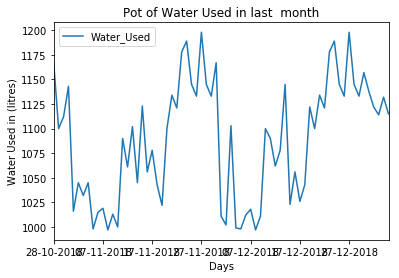

In [88]:
data[:].plot()
plt.xlabel('Days')
plt.ylabel('Water Used in (litres)')
plt.title('Pot of Water Used in last  month')
plt.show()

#### Generate some data

In [62]:
ts = np.array(data['Water_Used']).reshape((-1,1))

In [63]:
ts.shape

(69, 1)

#### Convert data into array that can be broken up into training "batches" that we will feed into our RNN model.  Note the shape of the arrays. 

In [64]:
TS = np.array(ts)
num_periods = 7
f_horizon = 1  #forecast horizon, one period into the future

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
#print(len(x_data))
#print("x_data : ",x_data)
x_batches = x_data.reshape(-1, 7, 1)

#print (len(x_batches))
print ("x_batches shape : ",x_batches.shape)
#print (x_batches[0:1])

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
#print(y_data.shape)
y_batches = y_data.reshape(-1, 7, 1)


#print ("y_batches : ",y_batches[0:1])
print ("y_batches shape : ",y_batches.shape)

x_batches shape :  (9, 7, 1)
y_batches shape :  (9, 7, 1)


#### Pull out our test data

In [65]:
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 7, 1)
    testY = TS[-(num_periods):].reshape(-1, 7, 1)
    return testX,testY

X_test, Y_test = test_data(TS,f_horizon,num_periods )
print (X_test.shape)
print(len(X_test))
#print (X_test)

print (Y_test.shape)
print(len(Y_test))
#print (Y_test)

(1, 7, 1)
1
(1, 7, 1)
1


In [66]:
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs

num_periods = 7      #number of periods per vector we are using to predict one period ahead
inputs = 1            #number of vectors submitted
hidden = 7          #number of neurons we will recursively work through, can be changed to improve accuracy
output = 1            #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs])   #create variable objects
y = tf.placeholder(tf.float32, [None, num_periods, output])

print(X)


basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)   #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)               #choose dynamic over static

learning_rate = 0.001   #small learning rate so we don't overshoot the minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])           #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)        #specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])          #shape of results
 
loss = tf.reduce_sum(tf.square(outputs - y))    #define the cost function which evaluates the quality of our model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #advanced gradient descent method 
training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 

init = tf.global_variables_initializer()           #initialize all the variables

Tensor("Placeholder:0", shape=(?, 7, 1), dtype=float32)


In [67]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("water_output", sess.graph)
    print(sess.run(init))
    writer.close()

None


In [68]:
epochs = 10000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
errors = []
iterations = []
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        errors.append(loss.eval(feed_dict={X: x_batches, y: y_batches}))
        iterations.append(ep)
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)  
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)
    

0 	MSE: 3327673.5
100 	MSE: 225659.12
200 	MSE: 173842.34
300 	MSE: 165485.53
400 	MSE: 163403.81
500 	MSE: 162644.25
600 	MSE: 162217.34
700 	MSE: 161849.11
800 	MSE: 161469.83
900 	MSE: 161066.44
1000 	MSE: 160638.27
1100 	MSE: 160186.23
1200 	MSE: 159711.62
1300 	MSE: 159218.47
1400 	MSE: 158703.16
1500 	MSE: 158170.1
1600 	MSE: 157621.11
1700 	MSE: 157058.1
1800 	MSE: 156483.53
1900 	MSE: 155899.84
2000 	MSE: 155309.64
2100 	MSE: 154715.73
2200 	MSE: 154121.08
2300 	MSE: 153533.27
2400 	MSE: 152945.53
2500 	MSE: 152365.92
2600 	MSE: 151797.5
2700 	MSE: 151242.77
2800 	MSE: 150704.31
2900 	MSE: 150184.48
3000 	MSE: 149685.14
3100 	MSE: 149208.02
3200 	MSE: 148759.5
3300 	MSE: 148329.84
3400 	MSE: 147924.89
3500 	MSE: 147545.17
3600 	MSE: 147190.45
3700 	MSE: 146860.33
3800 	MSE: 146553.88
3900 	MSE: 146270.3
4000 	MSE: 146008.23
4100 	MSE: 145766.44
4200 	MSE: 145543.17
4300 	MSE: 145337.34
4400 	MSE: 145147.06
4500 	MSE: 144973.45
4600 	MSE: 144809.28
4700 	MSE: 144656.47
4800 	MSE

In [69]:
for i in range(len(y_pred[0])):
    print(Y_test[0][i] , y_pred[0][i])

[1133] [1141.6178]
[1167] [1145.6373]
[1098] [1151.5029]
[1112] [1135.198]
[1134] [1101.5945]
[1132] [1092.292]
[1135] [1107.5293]


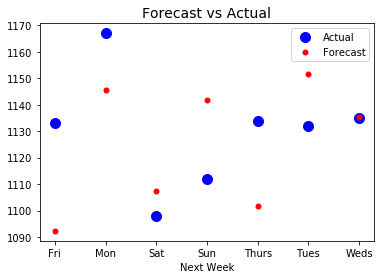

In [86]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo", markersize=10, label="Actual")
#plt.plot(pd.Series(np.ravel(Y_test)), "w*", markersize=10)
X = "Sun Mon Tues Weds Thurs Fri Sat ".split()
#X = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
plt.plot(X,pd.Series(np.ravel(y_pred), "r.", markersize=10, label="Forecast")
plt.legend()
plt.xlabel("Next Week")
plt.show()



In [85]:
"Sunday Monday Tuesday Wednesday Thursday Friday Saturday".split()

['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

1142.4352
2.436767578125
7


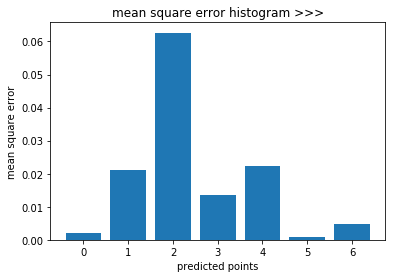

In [53]:
error = []
print(y_pred[0][1][0])
print(abs(y_pred[0][0][0]-Y_test[0][0][0]))
print(len(y_pred[0]))
for i in range(len(y_pred[0])):
    err = abs((y_pred[0][i][0]-Y_test[0][i][0])/Y_test[0][i][0])
    error.append(err)
x = np.arange(len(error))

plt.bar(x,error,align='center')
plt.xlabel('predicted points')
plt.ylabel('mean square error')
plt.title('mean square error histogram >>>')
plt.show()

(10000,)


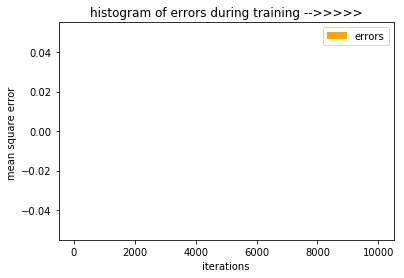

In [54]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

errors=np.array(errors)
iterations=np.array(iterations)
print(errors.shape)
#print(errors)

plt.hist(errors,iterations,label='errors', facecolor='orange')

plt.xlabel('iterations')
plt.ylabel('mean square error ')
plt.title('histogram of errors during training -->>>>>')
plt.legend()
plt.show()

(5000,)


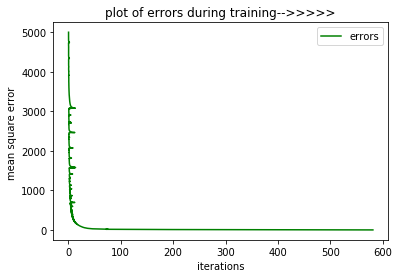

In [25]:
#!/usr/bin/env python
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

errors=np.array(errors)
iterations=np.array(iterations)
print(errors.shape)
#print(errors)

plt.plot(errors,iterations,label='errors',color='green')

plt.xlabel('iterations')
plt.ylabel('mean square error ')
plt.title('plot of errors during training-->>>>>')
plt.legend()
plt.show()